In [1]:
import numpy as np 
import pandas as pd 

import kagglehub
path = kagglehub.dataset_download("gmudit/employer-data")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/employer-data


In [2]:
import os

# Listar os arquivos baixados para encontrar o nome do arquivo CSV
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/employer-data/Employers_data.csv


       Employee_ID           Age  Experience_Years         Salary
count  10000.00000  10000.000000      10000.000000   10000.000000
mean    5000.50000     35.455900         12.370900  115381.500000
std     2886.89568     10.000213          9.148951   46066.139047
min        1.00000     21.000000          0.000000   25000.000000
25%     2500.75000     27.000000          5.000000   70000.000000
50%     5000.50000     34.000000         10.000000  120000.000000
75%     7500.25000     43.000000         19.000000  150000.000000
max    10000.00000     60.000000         37.000000  215000.000000
Employee_ID         0
Name                0
Age                 0
Gender              0
Department          0
Job_Title           0
Experience_Years    0
Education_Level     0
Location            0
Salary              0
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


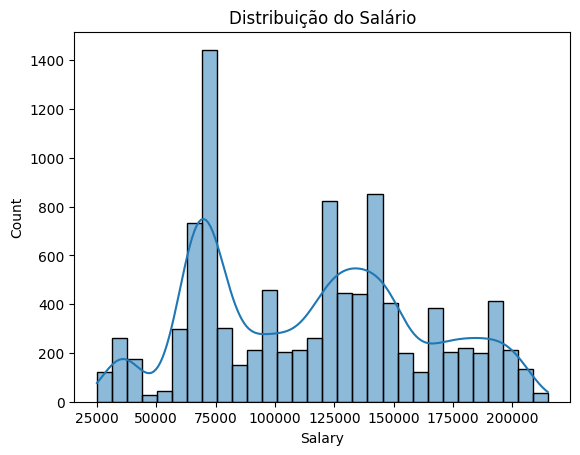

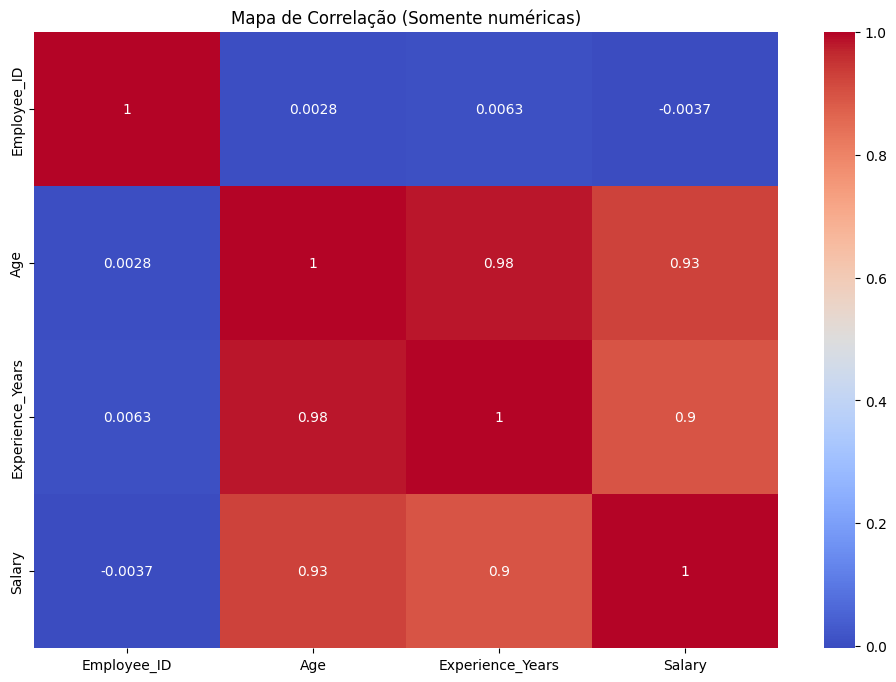

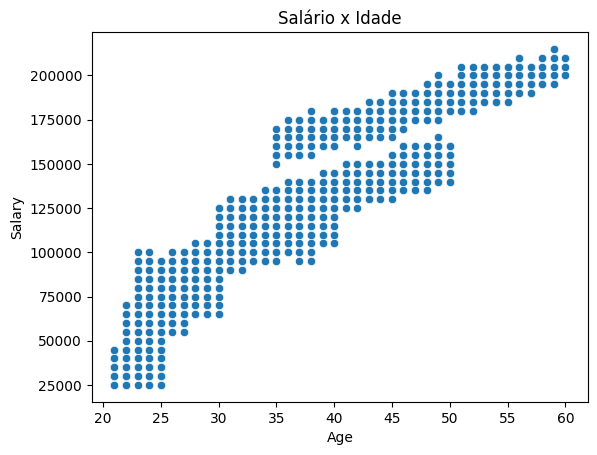

In [3]:
#análise exploratória dos dados 
import seaborn as sns
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/employer-data/Employers_data.csv')

# Estatísticas básicas
print(df.describe())

# Verificar valores nulos
print(df.isnull().sum())

# Distribuição do salário (target)
sns.histplot(df['Salary'], bins=30, kde=True)
plt.title('Distribuição do Salário')
plt.show()

# Correlação entre variáveis numéricas (inclui Salary)
# Seleciona só as colunas numéricas
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação (Somente numéricas)')
plt.show()

# Exemplo: salário vs idade 
sns.scatterplot(x='Age', y='Salary', data=df)
plt.title('Salário x Idade')
plt.show()

{'Analyst': 0, 'Engineer': 1, 'Executive': 2, 'Intern': 3, 'Manager': 4}
Mean Squared Error (MSE): 18699863.328923006
R^2 Score: 0.9911276744637542
      Employee_ID  Actual_Salary  Predicted_Salary
6252         6253         135000     137793.875000
4684         4685          70000      76009.929688
1731         1732          65000      68875.445312
4742         4743         125000     126336.851562
4521         4522         140000     143494.875000
...           ...            ...               ...
6412         6413         180000     176626.593750
8285         8286         205000     205911.656250
7853         7854         100000      96385.585938
1095         1096         185000     189198.703125
6929         6930          60000      64246.007812

[2000 rows x 3 columns]


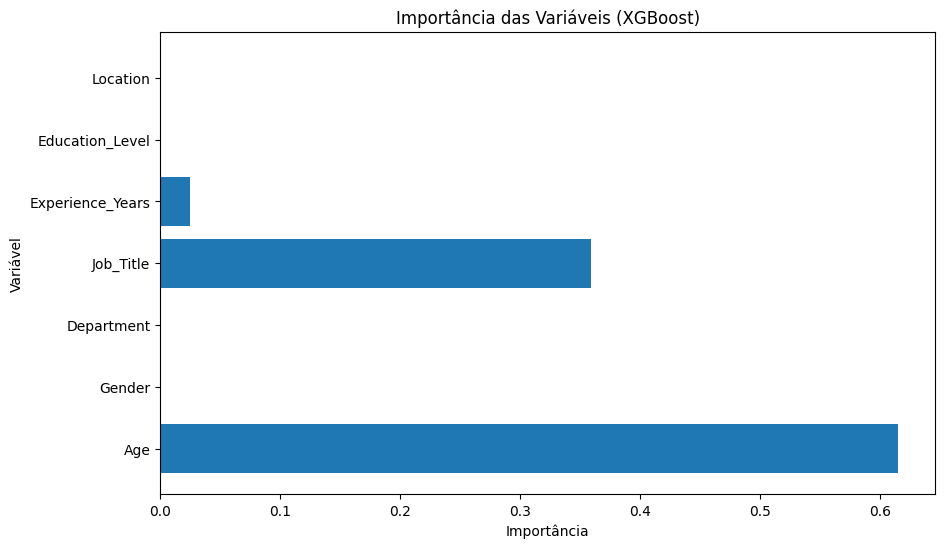

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Carregar Dataset
df = pd.read_csv('/kaggle/input/employer-data/Employers_data.csv')

# **Salvar Employee_ID para depois**
employee_ids = df['Employee_ID']

# 2. Remover colunas irrelevantes (mas deixar Employee_ID separado)
df_model = df.drop(['Employee_ID', 'Name'], axis=1)

le = LabelEncoder()
df_model['Job_Title'] = le.fit_transform(df_model['Job_Title'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

# 3. Label Encoding (para variáveis categóricas)
le = LabelEncoder()
for col in df_model.select_dtypes(include=['object']).columns:
    df_model[col] = le.fit_transform(df_model[col])

# 4. Separar Features (X) e Target (y)
X = df_model.drop('Salary', axis=1)
y = df_model['Salary']

# 5. Dividir em treino e teste mantendo índices para juntar depois
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, employee_ids, test_size=0.2, random_state=42)

# 6. Treinar Modelo XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 7. Previsões e Avaliação
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# 8. Criar DataFrame com Employee_ID, salário real e salário previsto
result_df = pd.DataFrame({
    'Employee_ID': idx_test,
    'Actual_Salary': y_test,
    'Predicted_Salary': y_pred
})

print(result_df)

# Obter importâncias das features
importances = xgb_model.feature_importances_
features = X.columns

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis (XGBoost)')
plt.show()


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(xgb_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [6]:
import xgboost as xgb

# Define o modelo com os melhores parâmetros
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=50,
    random_state=42
)

# Treina o modelo com os dados de treino completos
final_model.fit(X_train, y_train)

# Faz previsão no conjunto de teste (se você tiver)
y_pred = final_model.predict(X_test)

# Exemplo de avaliação, caso queira:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 18046726.59
R²: 0.99


In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_reg, X, y, cv=5, scoring='r2')
print(f'R² médio com Cross-Validation: {scores.mean():.3f}')

R² médio com Cross-Validation: 0.990


In [8]:
import pickle

# Salvar
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Carregar
with open('xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [9]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 3402.9797421875
RMSE: 4248.143898929347


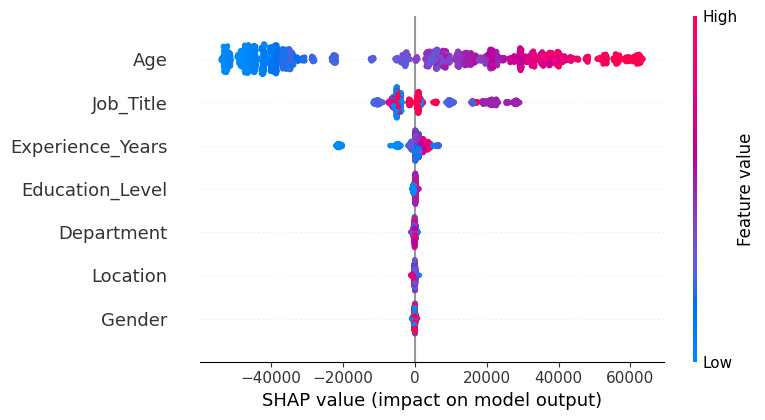

In [10]:
import shap
shap.initjs()
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Gráfico resumo
shap.summary_plot(shap_values, X_test)

# Exemplo gráfico de força para uma previsão
shap.plots.force(shap_values[0])